# Landmark-based Registration

#Introduction

This report had has objective to try to match through the use of homogeneous coordinates, Affine and Rigid transformation two different MRI images, a T1 and a T2. Bellow we can see a list of formulas used in the resolution of the tasks presented in this work :

\begin{gather}
x = Av + t \\
v_{T2} = M^{-1}(T2) \cdot M(T1) \cdot v_{T1} \\
v_{M} = M_{M}^{-1} \cdot M \cdot M_{F} \cdot v_{F}
\end{gather}

\

\begin{matrix} \begin{bmatrix} t_d \\ a_{d,1} \\ \vdots \\ a_{d,D} \end{bmatrix} = (X^T X)^{-1} X^T \begin{bmatrix} y_{1,d} \\ \vdots \\ y_{N,d} \end{bmatrix}, & \text{(2.8)} \end{matrix}

\

**where**  :


\begin{equation}
X = \begin{bmatrix}
1 & x_{1,1} & \cdots & x_{1,D} \\
1 & x_{2,1} & \cdots & x_{2,D} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{N,1} & \cdots & x_{N,D}
\end{bmatrix}
\end{equation}

\


\begin{equation}
t = \bar{y} - \bar{R}x
\end{equation}
\

\begin{gather}
E(w) = \sum_{n=1}^{N} \lVert \tilde{y}_n - \tilde{R}x_n \rVert^2 \\
\tilde{R} = VU^T \\
U^TU = I, \quad V^TV = I \\
\sum_{n=1}^{N} \tilde{x}_n \tilde{y}_n^T = U\Sigma V^T
\end{gather}





In [3]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions( suppress=True )
import nibabel as nib
import scipy

In [4]:
!pip install ipympl


In [5]:
USE_WIDGET = True   # if True: you will have an interactive plot integrated in the notebook.
                    #   False: an interactive window will pop out (use it if the widget does not work or if you prefer).

if USE_WIDGET:
    %matplotlib widget
else:
    %matplotlib tk

Read the two 3D scans you'll be working with in this exercise:

In [6]:
# Load T1 and T2 data
T1_fileName = 'IXI014-HH-1236-T1.nii.gz'
T2_fileName = 'IXI014-HH-1236-T2_moved.nii.gz'
T1 = nib.load( T1_fileName )
T2 = nib.load( T2_fileName )
T1_data = T1.get_fdata()
T2_data = T2.get_fdata()

Below is code to define a simple interactive viewer class that can be used to visualize 2D cross-sections of a 3D array along three orthogonal directions. It takes a 3D volume as input and shows the location a "linked cursor" in all three cross-sections.

In [7]:
class Viewer:
    def __init__(self, data ):
        self.fig, self.ax = plt.subplots()
        self.data = data
        self.dims = self.data.shape
        self.position = np.round( np.array( self.dims ) / 2 ).astype( int )
        self.draw()
        self.fig.canvas.mpl_connect( 'button_press_event', self )
        self.fig.show()

    def __call__(self, event):
        print( 'button pressed' )
        if event.inaxes is None: return

        x, y = round( event.xdata ), round( event.ydata )

        #
        if ( x > (self.dims[0]-1) ) and ( y <= (self.dims[1]-1) ): return # lower-right quadrant

        #
        if x < self.dims[0]:
          self.position[ 0 ] = x
        else:
          self.position[ 1 ] = x - self.dims[0]

        if y < self.dims[1]:
          self.position[ 1 ] = y
        else:
          self.position[ 2 ] = y -self.dims[1]

        print( f"  voxel index: {self.position}" )
        print( f"  intensity: {self.data[ self.position[0], self.position[1], self.position[2] ]}" )

        self.draw()

    def draw( self ):
        #
        # Layout on screen is like this:
        #
        #     ^            ^
        #  Z  |         Z  |
        #     |            |
        #     ----->        ---->
        #       X             Y
        #     ^
        #  Y  |
        #     |
        #     ----->
        #       X
        #
        dims = self.dims
        position = self.position

        xySlice = self.data[ :, :, position[ 2 ] ]
        xzSlice = self.data[ :, position[ 1 ], : ]
        yzSlice = self.data[ position[ 0 ], :, : ]

        kwargs = dict( vmin=self.data.min(), vmax=self.data.max(),
                       origin='lower',
                       cmap='gray',
                       picker=True )

        self.ax.clear()

        self.ax.imshow( xySlice.T,
                        extent=( 0, dims[0]-1,
                                 0, dims[1]-1 ),
                        **kwargs )
        self.ax.imshow( xzSlice.T,
                        extent=( 0, dims[0]-1,
                                 dims[1], dims[1]+dims[2]-1 ),
                        **kwargs )
        self.ax.imshow( yzSlice.T, extent=( dims[0], dims[0]+dims[1]-1,
                                            dims[1], dims[1]+dims[2]-1 ),
                        **kwargs )

        color = 'g'
        self.ax.plot( (0, dims[0]-1), (position[1], position[1]), color )
        self.ax.plot( (0, dims[0]+dims[1]-1), (dims[1]+position[2], dims[1]+position[2]), color )
        self.ax.plot( (position[0], position[0]), (0, dims[1]+dims[2]-1), color )
        self.ax.plot( (dims[0]+position[1], dims[0]+position[1]), (dims[1]+1, dims[1]+dims[2]-1), color )

        self.ax.set( xlim=(1, dims[0]+dims[1]), ylim=(0, dims[1]+dims[2]) )

        self.ax.text( dims[0] + dims[1]/2, dims[1]/2,
                      f"voxel index: {position}",
                      horizontalalignment='center', verticalalignment='center' )

        self.ax.axis( False )

        self.fig.canvas.draw()

The code below shows how to visualize the T1-weigthed and the T2-weighted volumes with this viewer class. The initial location of the cursor is in the middle of the volume in each case. It can be changed by clicking on one of the cross-sections. The viewer also displays the voxel index $\mathbf{v}$ of the cursor. Play around and try to understand what the ```Viewer()``` class does.

> ***Hint:***
> If the position of the linked cursor does not change when you click on one of the figures (i.e., you see a static image but interaction is not working), something is wrong with your Python set-up.
>
> On the Aalto jupyter servers at https://jupyter.cs.aalto.fi/, executing the following line seems to help:  ``` plt.switch_backend('nbAgg') ```

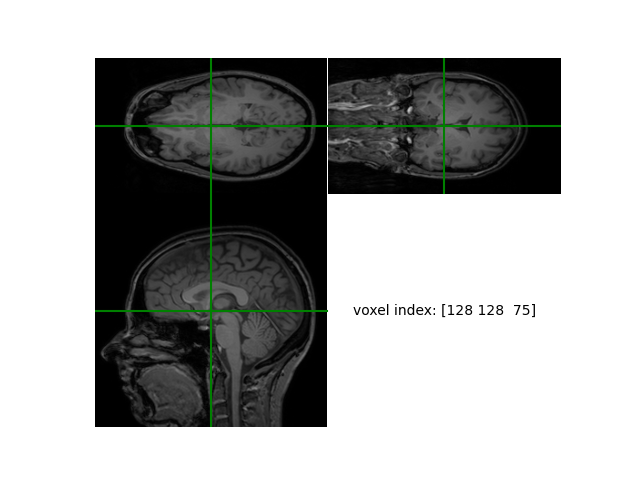

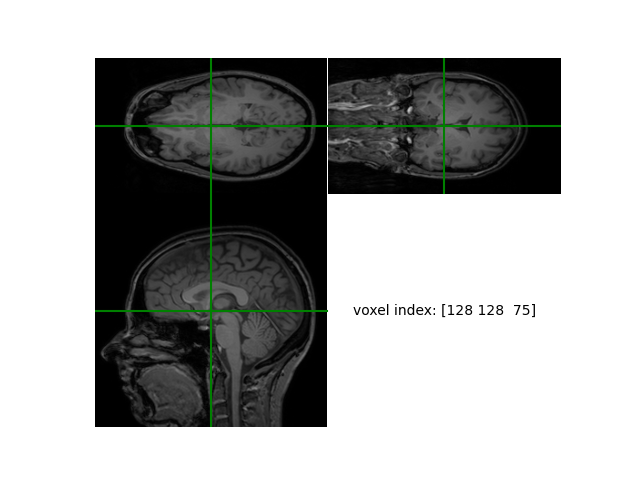

In [8]:


T1_viewer = Viewer( T1_data )

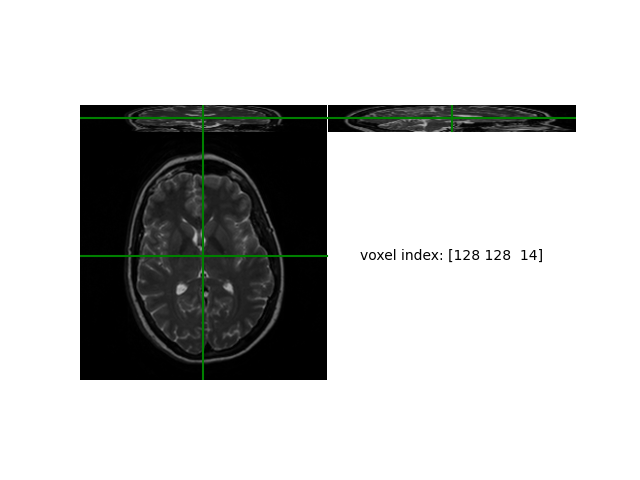

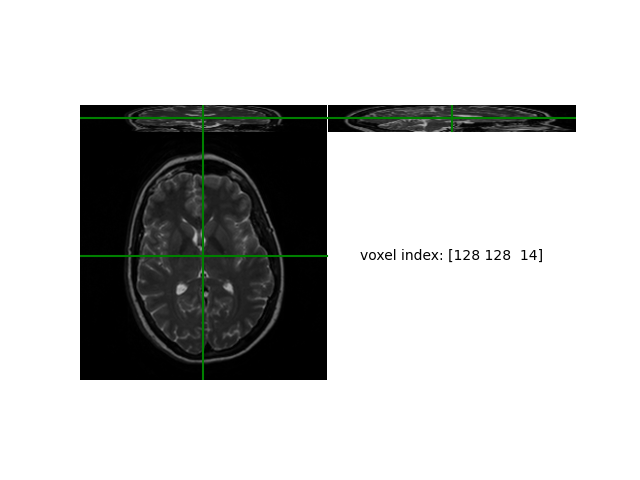

In [9]:
T2_viewer = Viewer( T2_data )

### Task 1: Coordinate Systems

Familiarize yourself with the concept of coordinate systems. In your report, explain why we need to differentiate between "voxel coordinates/indices" $\mathbf{v}$ and "world coordinates" $\mathbf{x}$. Why does the T2-weighted volume look so compressed in the viewer? For the enthusiastic student: calculate the voxel size in each dataset.

The world coordinate system used in both the T1-weighted and the T2-weighted scan follows the RAS convention. Equipped with this information, determine the voxel index $\mathbf{v}$ of the center of the left eye of the patient in the T1-weighted scan. Do the same for the T2-weighted scan.

> ***Hint:***
> The affine voxel-to-world matrix of the T1-weighted scan is given by: ``` T1.affine ```
>
        

# Answer

To connect images, we distinguish between "voxel coordinates" (integers used for indexing in a 3D grid) and "world coordinates" (real-world spatial positions in millimeters). Voxel coordinates, represented as (v1, v2, v3), index voxels within the image grid. The transformation from voxel to world coordinates is accomplished using a 3x3 matrix A and a 3x1 vector t, denoted as x = Av + t. This distinction is vital for aligning and interpreting images in medical and scientific contexts. We can transform them together and create an affine matrix :

\
\begin{matrix}
\begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ 1 \end{bmatrix} =
\begin{bmatrix} a_{1,1} & a_{1,2} & a_{1,3} & t_1 \\
                a_{2,1} & a_{2,2} & a_{2,3} & t_2 \\
                a_{3,1} & a_{3,2} & a_{3,3} & t_3 \\
                0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix} v_1 \\ v_2 \\ v_3 \\ 1 \end{bmatrix}
\end{matrix}

\


We were able to successfully transform what we obtained to world coordinates.




In [10]:
voxel_coordinate = np.array([80, 100, 75, 1]).T
world_coordinates_T1 = np.dot(T1.affine, voxel_coordinate)

voxel_coordinate = np.array([80, 100, 75, 1]).T
world_coordinates_T2 = np.dot(T2.affine, voxel_coordinate)

print(world_coordinates_T1)
print(world_coordinates_T2)

[ -0.29722822  57.39971083 -17.49692983   1.        ]
[ -6.68842524 -13.07661003 297.31788662   1.        ]


### Task 2: Resample the T2-weighted scan to the image grid of the T1-weighted scan

In this task you should resample the T2-weighted scan to the image grid of the T1-weighted scan, i.e., create a new 3D volume that has the same size as the T1-weighted volume, but that contains interpolated T2-weighted intensities instead. In particular, for each voxel index $\mathbf{v}_{T1}$ in the T1-weighted image grid, you should compute the corresponding voxel index $\mathbf{v}_{T2}$ in the T2-weighted volume as follows (see section 2.1 in the book):
$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
.
$$
At the location $\mathbf{v}_{T2}$, you should then use cubic B-spline interpolation to determine the intensity in the T2-weighted scan, and store it at index $\mathbf{v}_{T1}$ in the newly created image.


> ***Hints:***
> - you can create a coordinate grid in 3D with the function
>
>        V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ),
>                                np.arange( T1_data.shape[1] ),
>                                np.arange( T1_data.shape[2] ), indexing='ij' )
>   
>
> - the following SciPy function interpolates the T2-weighted volume at voxel coordinates $(1.1,2.2,3.3)^T$
> and $(6.6,7.7,8.8)^T$ using cubic interpolation:   
>
>        T2_data_resampled = scipy.ndimage.map_coordinates( T2_data, np.array( [ [1.1,2.2,3.3], [6.6,7.7,8.8] ] ).T )
>

#Answer

Here, the objective was accomplished and we successfully managed to resample the T2 - weighted scan to the image grid of the T1 - weighted scan by creating a new 3D volume using np.meshgrid and applying the consecutive affine transformations to world coordinates as it was presented in the question. In the end we overlapped the images to check our results. We successfully accomplished the task at hand.

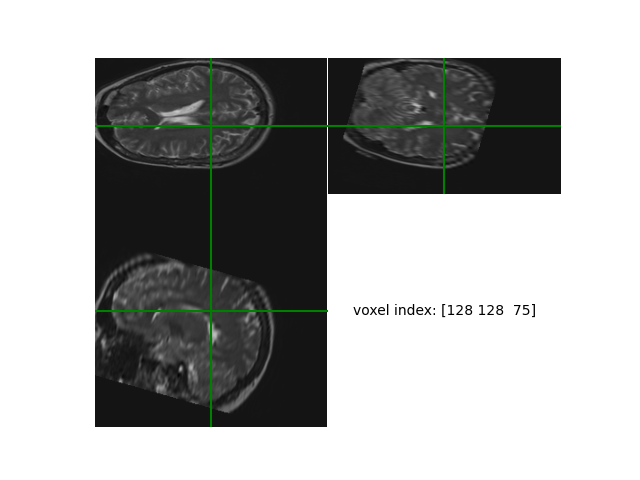

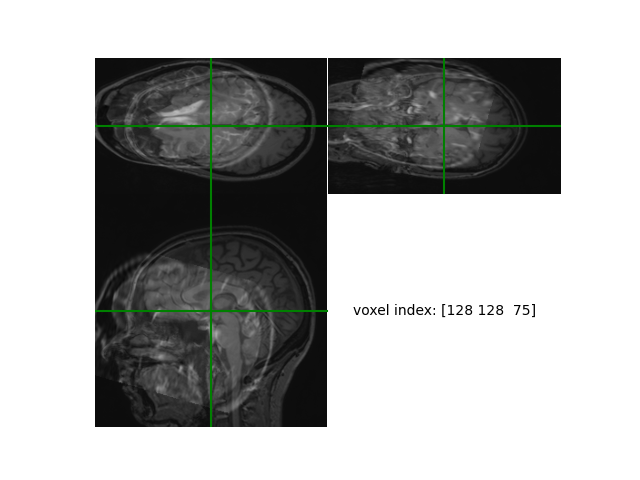

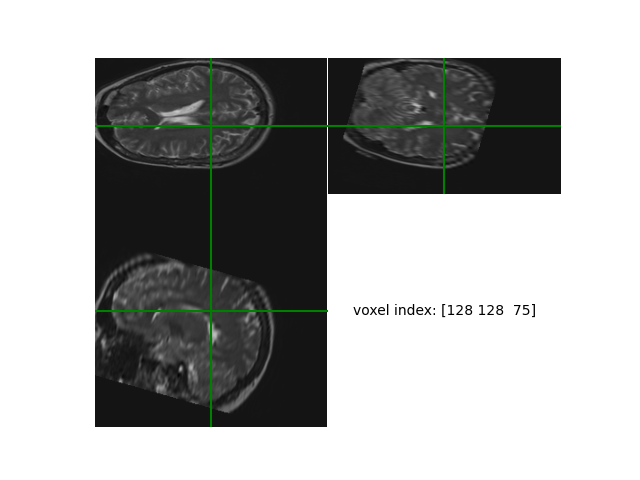

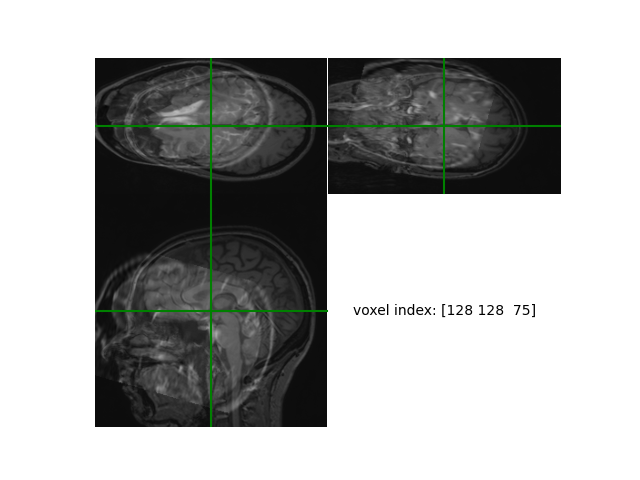

In [12]:
import numpy as np
import scipy.ndimage

# Create a coordinate grid in 3D
V1, V2, V3 = np.meshgrid(np.arange(T1_data.shape[0]),
                         np.arange(T1_data.shape[1]),
                         np.arange(T1_data.shape[2]), indexing='ij')

# Stack the coordinate grid to create a 4xN array of homogeneous coordinates
homogeneous_coordinates = np.vstack((V1.flatten(), V2.flatten(), V3.flatten(), np.ones(V1.size)))

# Transform the coordinates from T1 to T2
transformed_coordinates = np.linalg.inv(T2.affine) @ T1.affine @ homogeneous_coordinates

# Use cubic B-spline interpolation to determine the intensity in the T2-weighted scan
T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, transformed_coordinates[:3], order=3)

# Reshape the result to match the shape of T1_data
T2_data_resampled = T2_data_resampled.reshape(T1_data.shape)

Viewer(T2_data_resampled)
Viewer(T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max())

Once you have created a new volume like this, visualize it overlaid on the T1-weighted volume as follows:

 ``` Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() ) ```

### Task 3: Collect corresponding landmarks

Using the viewer class, record the voxel coordinates $\mathbf{v_{T1}}$ and $\mathbf{v_{T2}}$ of at least five corresponding landmarks in the T1- and the T2-weighted volumes, respectively. List them in your report, and explain why you picked them.

> ***Hint:***
> - Avoid picking landmarks that are very close to each other or that all lie approximately in the same 2D plane.
> - You can double-check which landmarks you've selected as follows:
> ```
>         T1_viewer = Viewer( T1_data )
>         T1_viewer.position = ( 20, 30, 40 )
>         T1_viewer.draw()
> ```


#Answer

Here, the objective was to choose 5 landmarks that matched by looking at T1 and T2. These five landmarks were chosen to be able to have a correspondence between 5 different regions in different planes of the human brain. Therefore we chose regions distant from each other such as the cerebellum, cerebral cortex, prefrontal cortex, occipital cortex and the nose. We already added the one to convert them into homogeneous coordinates.

In [13]:
cerebellum_T1 = np.array([184, 106, 75, 1])
cerebral_cortex_T1 = np.array([149, 193, 108,1])
prefrontal_cortex_T1 = np.array([59, 162, 43,1])
occipital_lobe_T1 = np.array([237, 155, 74,1])
nose_T1 = np.array([10, 77, 75,1])

cerebellum_T2 = np.array([131, 85, 7, 1])
cerebral_cortex_T2 = np.array([171, 127, 26,1])
prefrontal_cortex_T2 = np.array([84, 211, 17,1])
occipital_lobe_T2 = np.array([131, 25, 17,1])
nose_T2 = np.array([121, 250, 1,1])


### Task 4: Perform affine landmark-based registration

Using the landmarks you recorded in the previous task, compute the parameters of the 3D affine transformation that brings the landmarks in the T1-weighted image closest to the corresponding ones in the T2-weighted image. For this purpose, use Equation (2.8) in the book.

Once you've determined the affine transformation, register to two images by resampling the T2-weighted image to the image grid of the T1-weighted image, and overlay the two images as in Task 2.

To map voxel coordinates $\mathbf{v}_{T1}$ to $\mathbf{v}_{T2}$, you'll have to use:
$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
,
$$
where $\mathbf{M}$ is your $4 \times 4$ affine matrix (see book).

What happens when you increase/decrease the number of corresponding landmarks that are used in the computations? Comment.

> ***Hint:***
> - remember that the affine matrix works in *world* coordinates, so you'll have to map your landmarks to world coordinates first.
> - you can use  ``` np.hstack() ``` to append a column of ones to an existing matrix (e.g., to construct the $\mathbf{X}$ matrix in Equation (2.8) in the book).
>

#Answer

In task 4, we achieved a notable improvement in aligning the two images. Specifically, in the case of affine transformation, we observed that reducing the number of landmarks led to a lower-quality image alignment, while increasing the number of landmarks resulted in a significantly improved alignment. This phenomenon can be attributed to the quantity and quality of the data used to derive the transformation matrix, denoted as M.

When we incorporate more correctly matched landmarks, the transformation becomes more accurate. This is because a higher number of well-matched points allows for a more precise minimization of the energy term in the Least Squares formula. By selecting the correct points, we enhance the overall accuracy of the transformation, and the more such points we incorporate, the more favorable the results become.

$E(w) = \sum_{n=1}^{N} \left\| y_n - y(x_n, w) \right\|^2$

We were able to obtain both matrix A and X by using this deductions :

\

\begin{matrix} \begin{bmatrix} t_d \\ a_{d,1} \\ \vdots \\ a_{d,D} \end{bmatrix} = (X^T X)^{-1} X^T \begin{bmatrix} y_{1,d} \\ \vdots \\ y_{N,d} \end{bmatrix}, & \text{(2.8)} \end{matrix}

\

**where**  :


\begin{equation}
X = \begin{bmatrix}
1 & x_{1,1} & \cdots & x_{1,D} \\
1 & x_{2,1} & \cdots & x_{2,D} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{N,1} & \cdots & x_{N,D}
\end{bmatrix}
\end{equation}

\

Also worth mentioning that a good choice of landmarks is also important because we can only choose 5. The landmarks should be chosen to be as most far away from each other as possible so that a good general representation of the brain can be obtained.


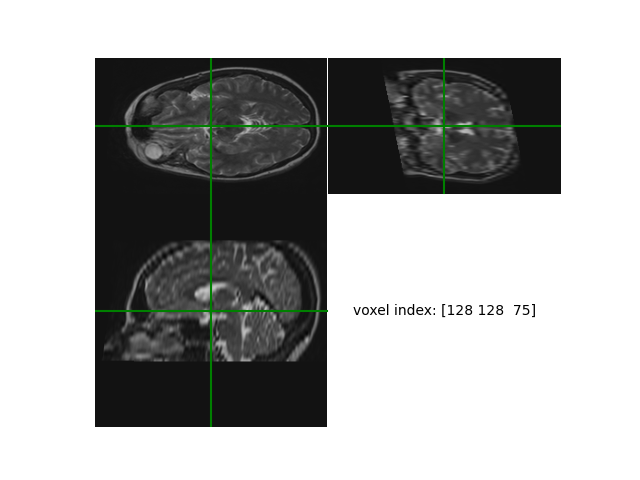

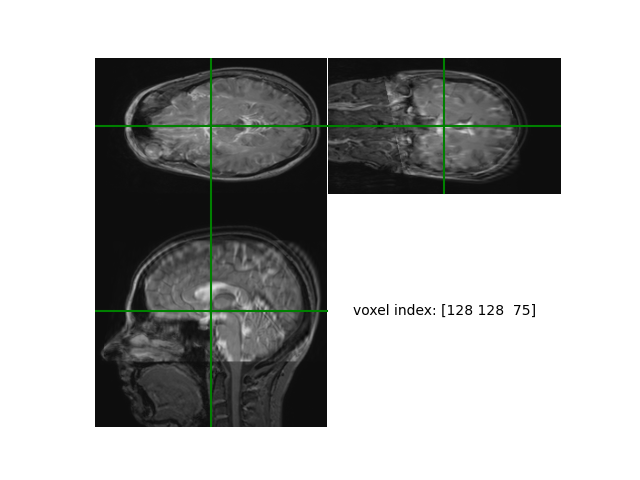

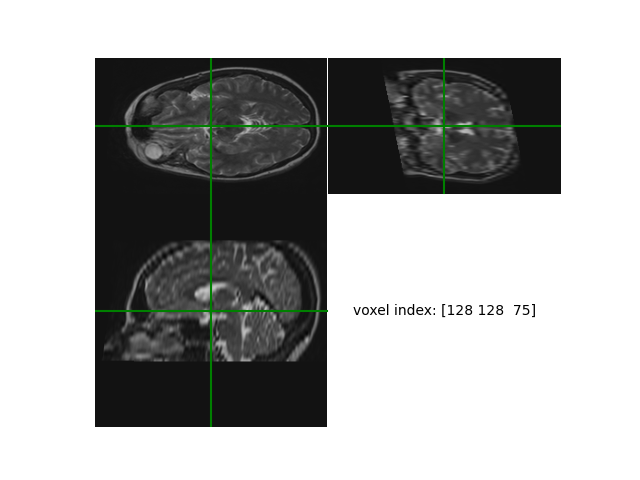

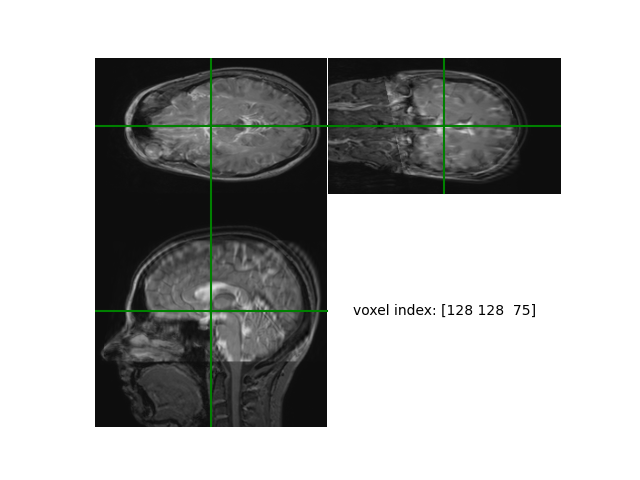

In [14]:
# Five landmarks

landmarks_T1_voxel = np.vstack((cerebellum_T1, cerebral_cortex_T1, prefrontal_cortex_T1, occipital_lobe_T1, nose_T1))
landmarks_T2_voxel = np.vstack((cerebellum_T2, cerebral_cortex_T2, prefrontal_cortex_T2, occipital_lobe_T2, nose_T2))

voxels_T1 = landmarks_T1_voxel.T
voxels_T2 = landmarks_T2_voxel.T

new_world_coordinates_T1 = np.dot(T1.affine, voxels_T1)
new_world_coordinates_T2 = np.dot(T2.affine, voxels_T2)

# placing X with the correct dimensions and the right format
X = new_world_coordinates_T1.T
X = np.hstack((np.ones((X.shape[0], 1)), X))
X = X[:,:-1]

# Compute A using Equation (2.8) and placing it in the last column
A = np.linalg.inv(X.T @ X) @ X.T @ new_world_coordinates_T2.T
A = A.T
first_column = A[:,0]
A = A[:,1:]
A = np.column_stack((A, first_column))

transformed_coordinates = np.linalg.inv(T2.affine) @ A @ T1.affine @ homogeneous_coordinates
# Use cubic B-spline interpolation to determine the intensity in the T2-weighted scan

T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, transformed_coordinates[:3], order=3)
# Reshape the result to match the shape of T1_data

T2_data_resampled = T2_data_resampled.reshape(T1_data.shape)
Viewer(T2_data_resampled)
Viewer((T2_data_resampled / T2_data_resampled.max()) + (T1_data / T1_data.max()))


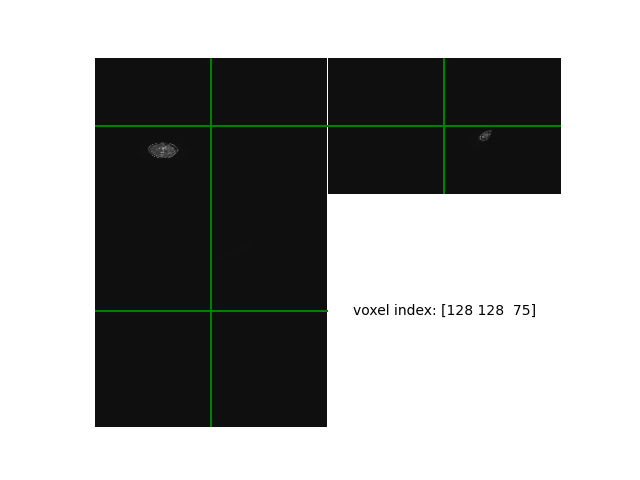

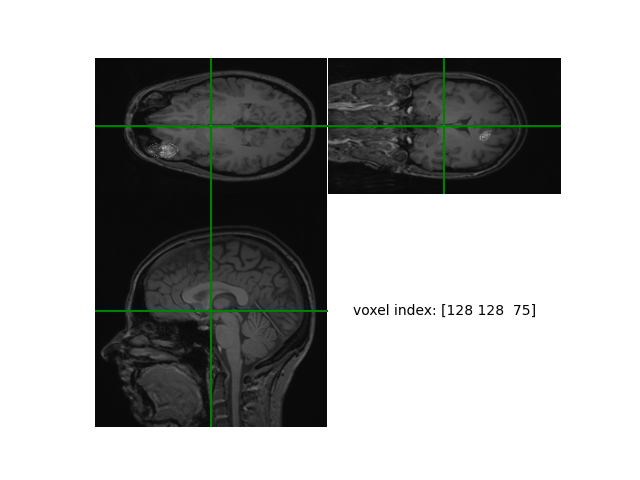

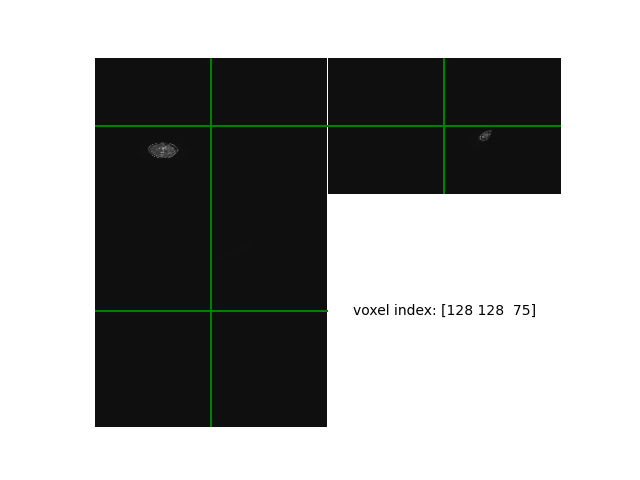

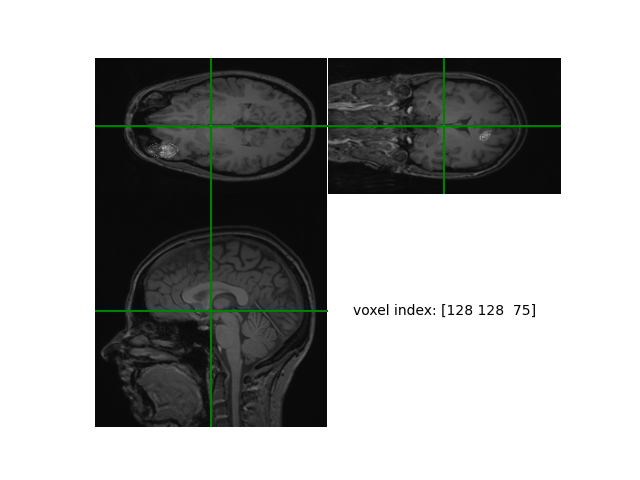

In [15]:
# Three landmarks

landmarks_T1_voxel = np.vstack((cerebellum_T1, cerebral_cortex_T1, prefrontal_cortex_T1))
landmarks_T2_voxel = np.vstack((cerebellum_T2, cerebral_cortex_T2, prefrontal_cortex_T2))

voxels_T1 = landmarks_T1_voxel.T
voxels_T2 = landmarks_T2_voxel.T

new_world_coordinates_T1 = np.dot(T1.affine, voxels_T1)
new_world_coordinates_T2 = np.dot(T2.affine, voxels_T2)

# placing X with the correct dimensions and the right format
X = new_world_coordinates_T1.T
X = np.hstack((np.ones((X.shape[0], 1)), X))
X = X[:,:-1]

# Compute A using Equation (2.8) and placing it in the last column
A = np.linalg.inv(X.T @ X) @ X.T @ new_world_coordinates_T2.T
A = A.T
first_column = A[:,0]
A = A[:,1:]
A = np.column_stack((A, first_column))

transformed_coordinates = np.linalg.inv(T2.affine) @ A @ T1.affine @ homogeneous_coordinates
# Use cubic B-spline interpolation to determine the intensity in the T2-weighted scan

T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, transformed_coordinates[:3], order=3)
# Reshape the result to match the shape of T1_data

T2_data_resampled = T2_data_resampled.reshape(T1_data.shape)

Viewer(T2_data_resampled)
Viewer((T2_data_resampled / T2_data_resampled.max()) + (T1_data / T1_data.max()))



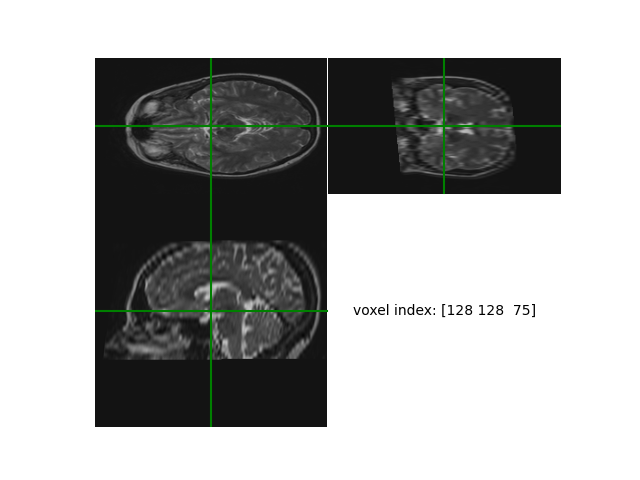

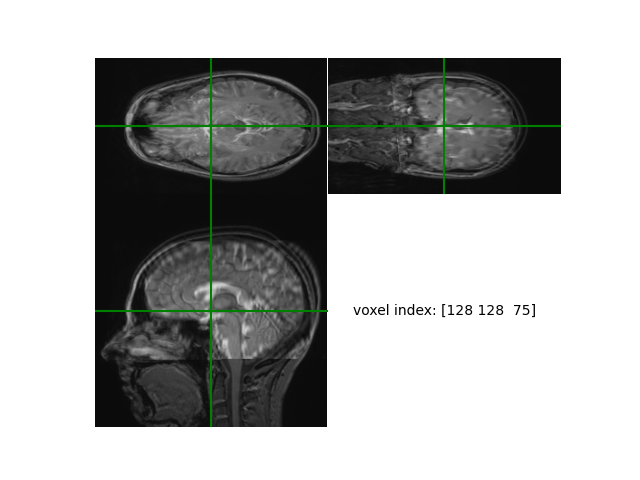

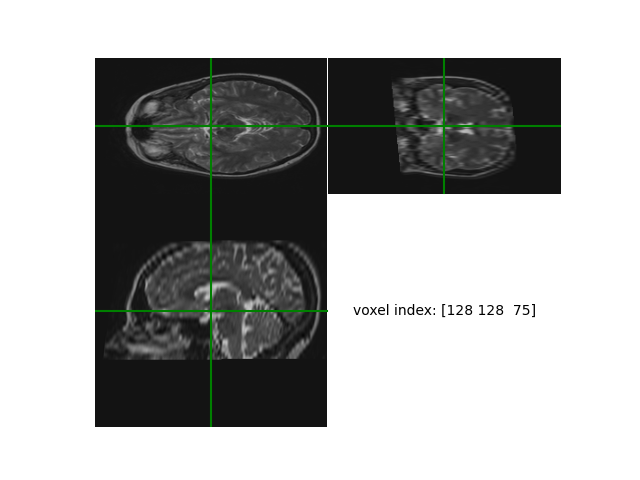

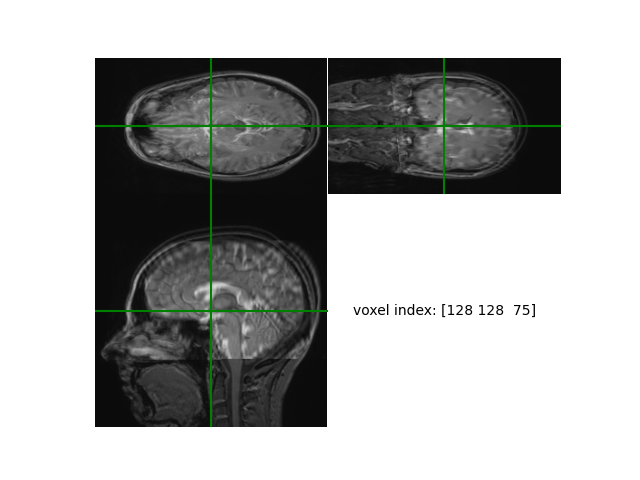

In [16]:
# Six landmarks

back_of_neck_T1 = np.array([198, 127, 120,1])
back_of_neck_T2 = np.array([201, 74, 11,1])

landmarks_T1_voxel = np.vstack((cerebellum_T1, cerebral_cortex_T1, prefrontal_cortex_T1, occipital_lobe_T1, nose_T1, back_of_neck_T1))
landmarks_T2_voxel = np.vstack((cerebellum_T2, cerebral_cortex_T2, prefrontal_cortex_T2, occipital_lobe_T2, nose_T2, back_of_neck_T2))

voxels_T1 = landmarks_T1_voxel.T
voxels_T2 = landmarks_T2_voxel.T

new_world_coordinates_T1 = np.dot(T1.affine, voxels_T1)
new_world_coordinates_T2 = np.dot(T2.affine, voxels_T2)

# placing X with the correct dimensions and the right format
X = new_world_coordinates_T1.T
X = np.hstack((np.ones((X.shape[0], 1)), X))
X = X[:,:-1]

# Compute A using Equation (2.8) and placing it in the last column
A = np.linalg.inv(X.T @ X) @ X.T @ new_world_coordinates_T2.T
A = A.T
first_column = A[:,0]
A = A[:,1:]
A = np.column_stack((A, first_column))

transformed_coordinates = np.linalg.inv(T2.affine) @ A @ T1.affine @ homogeneous_coordinates

# Use cubic B-spline interpolation to determine the intensity in the T2-weighted scan
T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, transformed_coordinates[:3], order=3)

# Reshape the result to match the shape of T1_data
T2_data_resampled = T2_data_resampled.reshape(T1_data.shape)

Viewer(T2_data_resampled)
Viewer((T2_data_resampled / T2_data_resampled.max()) + (T1_data / T1_data.max()))

### Task 5: Perform rigid landmark-based registration

Repeat Task 4, but this time using a *rigid* transformation model. Vary the number of landmarks that are used again, and comment. Which transformation model (affine or rigid) is more appropriate to use in this specific application?

> ***Hint:***
> - a singular value decomposition can be computed using: ``` np.linalg.svd() ```
>
> - the determinant of a matrix can be computed using: ``` np.linalg.det()```
>


#Answer

Regarding task 5 we were able to obtain the best result with less landmarks. This is due to the inhate difference between an affine transformation and a Rigid transformation. In the affine transformation angles and areas are tipically not preserved, only the straight lines, therefore this allows a higher level of distortion and matching between the different images. In the rigid transformation we can only only rotate and translate which means that images that are inherently different by having different sizes will be hard to match with each other. In this task it was verified that the number of landmarks that achieved the best result (we can verify this by simply looking at them) was with three landmarks. This can be because the there might be local minimum in the least squares calculations that also is able to minimize the landmarks provided. Which also makes sense because when considering only rotations and translations, as long as the landmarks match with each other, there is the existence of a local minimum.

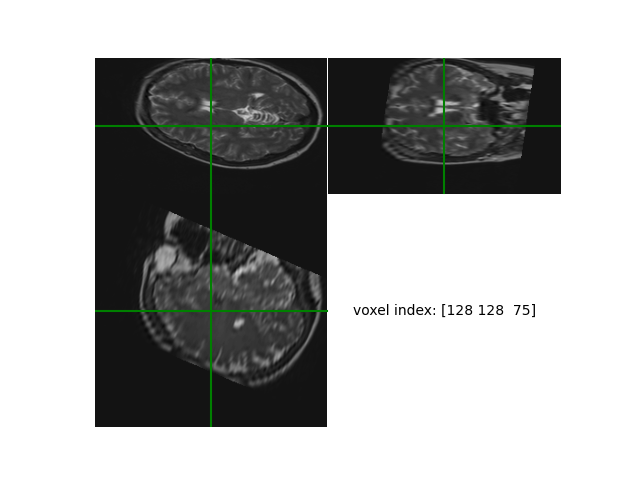

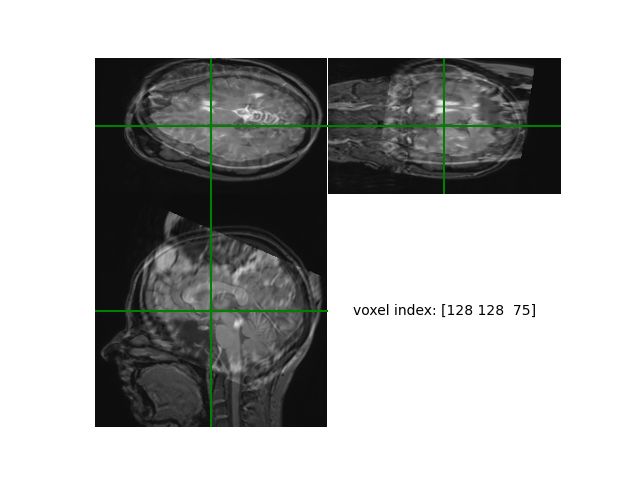

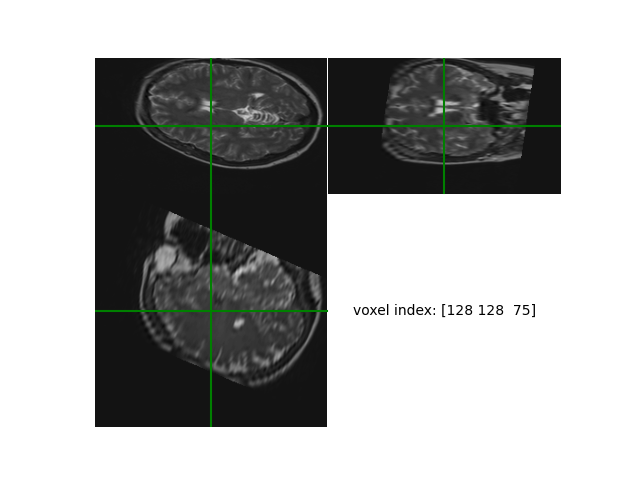

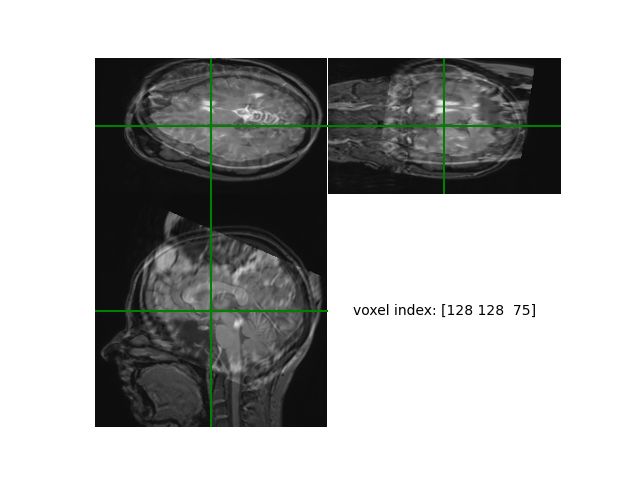

In [17]:
# Five landmarks

selected_landmarks_T1 = np.array((cerebellum_T1, cerebral_cortex_T1, prefrontal_cortex_T1, occipital_lobe_T1, nose_T1))
selected_landmarks_T2 = np.array((cerebellum_T2, cerebral_cortex_T2, prefrontal_cortex_T2, occipital_lobe_T2, nose_T2))


voxels_T1 = landmarks_T1_voxel.T
voxels_T2 = landmarks_T2_voxel.T

new_world_coordinates_T1 = np.dot(T1.affine, voxels_T1)
new_world_coordinates_T2 = np.dot(T2.affine, voxels_T2)

# Compute the centroid of each set of landmarks
centroid_T1 = np.mean(new_world_coordinates_T1.T, axis=0)
centroid_T2 = np.mean(new_world_coordinates_T2.T, axis=0)

# Center the landmarks by subtracting the centroid
centered_landmarks_T1 = selected_landmarks_T1 - centroid_T1
centered_landmarks_T2 = selected_landmarks_T2 - centroid_T2


# Compute the covariance matrix
covariance_matrix = np.dot(centered_landmarks_T1.T, centered_landmarks_T2)



# Perform SVD to get rotation matrix R
U, _, Vt = np.linalg.svd(covariance_matrix)
R = np.dot(U, Vt)

# Ensure determinant constraint
if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = np.dot(U, Vt)

# Compute the translation vector t
t = centroid_T2 - np.dot(R, centroid_T1)

R[:, -1] += t

transformed_coordinates = np.linalg.inv(T2.affine) @ R @ T1.affine @ homogeneous_coordinates

T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, transformed_coordinates[:3], order=3)
T2_data_resampled = T2_data_resampled.reshape(T1_data.shape)

Viewer(T2_data_resampled)
Viewer((T2_data_resampled / T2_data_resampled.max()) + (T1_data / T1_data.max()))



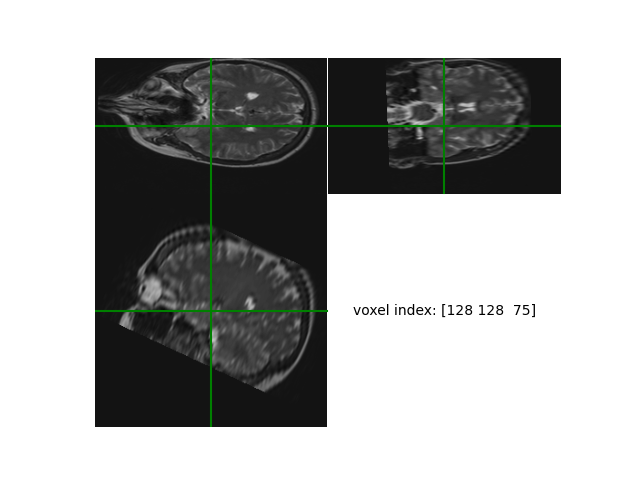

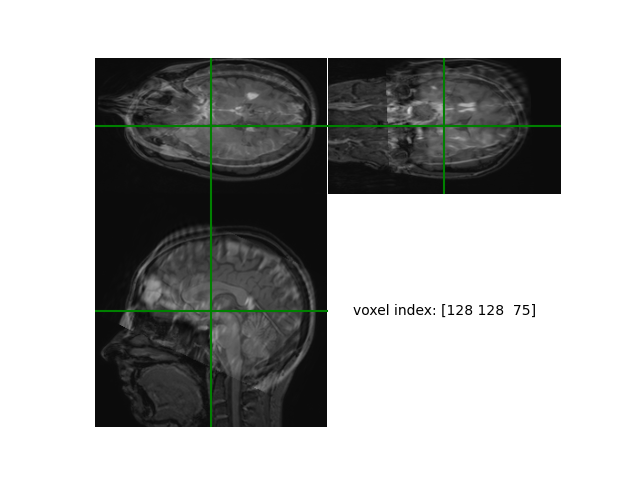

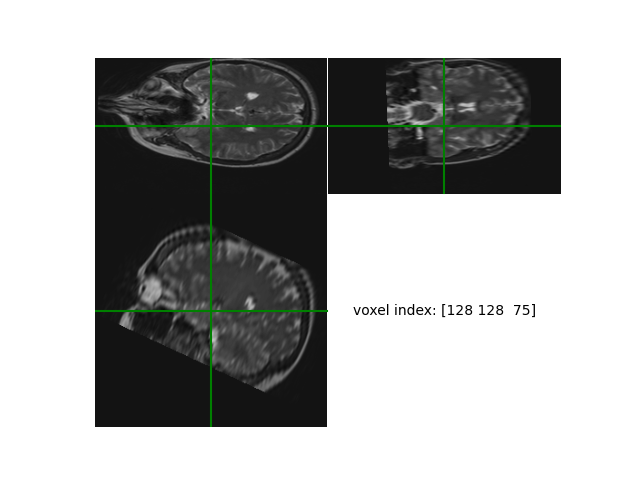

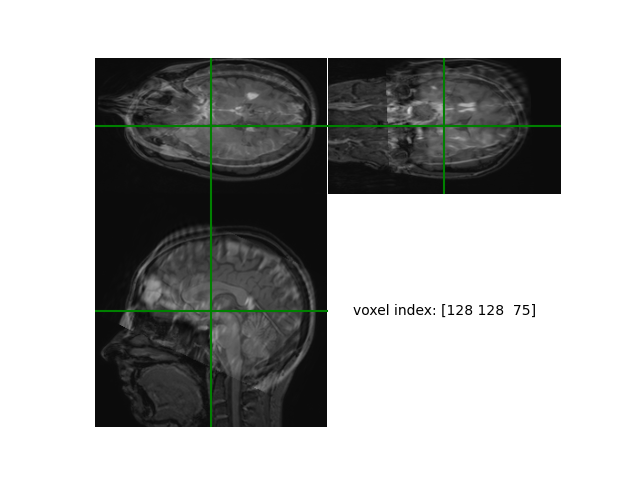

In [18]:
# Three landmarks

selected_landmarks_T1 = np.array([cerebellum_T1, cerebral_cortex_T1, prefrontal_cortex_T1])
selected_landmarks_T2 = np.array([cerebellum_T2, cerebral_cortex_T2, prefrontal_cortex_T2])

voxels_T1 = landmarks_T1_voxel.T
voxels_T2 = landmarks_T2_voxel.T

new_world_coordinates_T1 = np.dot(T1.affine, voxels_T1)
new_world_coordinates_T2 = np.dot(T2.affine, voxels_T2)

# Compute the centroid of each set of landmarks
centroid_T1 = np.mean(new_world_coordinates_T1.T, axis=0)
centroid_T2 = np.mean(new_world_coordinates_T2.T, axis=0)

# Center the landmarks by subtracting the centroid
centered_landmarks_T1 = selected_landmarks_T1 - centroid_T1
centered_landmarks_T2 = selected_landmarks_T2 - centroid_T2

# Compute the covariance matrix
covariance_matrix = np.dot(centered_landmarks_T1.T, centered_landmarks_T2)

# Perform SVD to get rotation matrix R
U, _, Vt = np.linalg.svd(covariance_matrix)
R = np.dot(U, Vt)

# Ensure determinant constraint
if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = np.dot(U, Vt)

# Compute the translation vector t
t = centroid_T2 - np.dot(R, centroid_T1)

R[:, -1] += t

transformed_coordinates = np.linalg.inv(T2.affine) @ R @ T1.affine @ homogeneous_coordinates

T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, transformed_coordinates[:3], order=3)
T2_data_resampled = T2_data_resampled.reshape(T1_data.shape)

Viewer(T2_data_resampled)
Viewer((T2_data_resampled / T2_data_resampled.max()) + (T1_data / T1_data.max()))

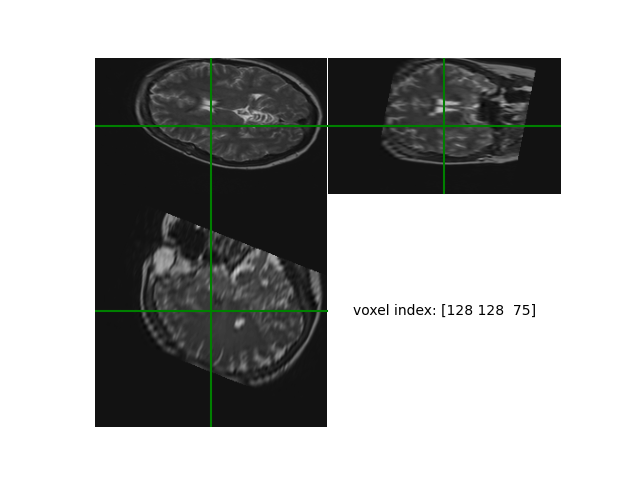

In [ ]:
# Six landmarks

selected_landmarks_T1 = np.array((cerebellum_T1, cerebral_cortex_T1, prefrontal_cortex_T1, occipital_lobe_T1, nose_T1, back_of_neck_T1))
selected_landmarks_T2 = np.array((cerebellum_T2, cerebral_cortex_T2, prefrontal_cortex_T2, occipital_lobe_T2, nose_T2, back_of_neck_T2))


voxels_T1 = landmarks_T1_voxel.T
voxels_T2 = landmarks_T2_voxel.T

new_world_coordinates_T1 = np.dot(T1.affine, voxels_T1)
new_world_coordinates_T2 = np.dot(T2.affine, voxels_T2)

# Compute the centroid of each set of landmarks
centroid_T1 = np.mean(new_world_coordinates_T1.T, axis=0)
centroid_T2 = np.mean(new_world_coordinates_T2.T, axis=0)

# Center the landmarks by subtracting the centroid
centered_landmarks_T1 = selected_landmarks_T1 - centroid_T1
centered_landmarks_T2 = selected_landmarks_T2 - centroid_T2

# Compute the covariance matrix
covariance_matrix = np.dot(centered_landmarks_T1.T, centered_landmarks_T2)

# Perform SVD to get rotation matrix R
U, _, Vt = np.linalg.svd(covariance_matrix)
R = np.dot(U, Vt)

# Ensure determinant constraint
if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = np.dot(U, Vt)

# Compute the translation vector t
t = centroid_T2 - np.dot(R, centroid_T1)

R[:, -1] += t

transformed_coordinates = np.linalg.inv(T2.affine) @ R @ T1.affine @ homogeneous_coordinates

T2_data_resampled = scipy.ndimage.map_coordinates(T2_data, transformed_coordinates[:3], order=3)
T2_data_resampled = T2_data_resampled.reshape(T1_data.shape)

Viewer(T2_data_resampled)
Viewer((T2_data_resampled / T2_data_resampled.max()) + (T1_data / T1_data.max()))

#Conclusion

This report aimed to achieve image matching between two distinct MRI images, a T1 and a T2, through the application of homogeneous coordinates, Affine, and Rigid transformations.

Our work demonstrated successful resampling of the T2-weighted scan to the image grid of the T1-weighted scan by creating a new 3D volume using `np.meshgrid` and applying consecutive affine transformations to world coordinates.

The selection of five strategically chosen landmarks, representing various brain regions, played a vital role in achieving image alignment. These landmarks were converted into homogeneous coordinates.

In Task 4, we observed a significant improvement in image alignment. A reduction in the number of landmarks led to a less satisfactory result, while an increase in landmarks enhanced the alignment. This improvement can be attributed to the quality and quantity of data used to derive the transformation matrix, resulting in more accurate minimization of the energy term in the Least Squares formula.

In Task 5, a better result was achieved with fewer landmarks, emphasizing the inherent differences between affine and Rigid transformations. Affine transformations allow for more distortion and improved matching between different images, whereas Rigid transformations are limited to rotations and translations, making it challenging to match inherently different images. We observed that three landmarks achieved the best results, possibly due to the existence of local minima in the Least Squares calculations, which can effectively minimize the provided landmarks.

Therefore I conclude that the affine transformation is better that the rotatio because the primary challenge pertains to differing image sizes. While affine transformation consistently yields superior results under these conditions, it's important to note that the choice between affine and rigid rotation may vary in scenarios with distinct image orientations, angles, and locations. The key takeaway is the need to select the appropriate transformation method based on the unique characteristics and challenges presented by the images in question.
